In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars

from models.setup import ModelSetup
from models.build import create_multimodal_rcnn_model
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss, get_params
from utils.init import reproducibility, clean_memory_get_device
from data.constants import DEFAULT_REFLACX_LABEL_COLS
from data.paths import MIMIC_EYE_PATH
from datetime import datetime
from utils.coco_utils import get_cocos
from utils.coco_eval import get_eval_params_dict
from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim, nn


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [4]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [5]:
if "cuda" in device:
    torch.cuda.memory_summary()

| Total GPU	|: [55552131312]
| Reserved	|: [2131]
| Allocated	|: [321312312]
| Free:		|: [13121231]


In [6]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

common_args = {
    # "use_custom_model": True,
    # "use_early_stop_model": True,
    "optimiser": "sgd",
    "lr": 1e-3,
    "weight_decay": 1e-5,
    # "pretrained": True,
    "record_training_performance": True,
    # "dataset_mode": "normal",
    "image_size": 512,
    "batch_size": 1,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": False,
    # "clinical_num_len": len(DEFAULT_MIMIC_CLINICAL_NUM_COLS),
    "gt_in_train_till": 999,
    "box_head_dropout_rate": 0,
    # "spatialise_method": "convs",  # [convs, repeat]
    # "normalise_clinical_num": False,
    "measure_test": True,
}

fusion_add_args = {
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "add",
}

fusion_concat_args = {
    "fuse_depth": 1,
    "fusion_residule": False,
    "fusion_strategy": "concat",
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    # "clinical_input_channels": 64,
    "representation_size": 64,  # 32
    # "clinical_conv_channels": 64,
    # "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

large_model_args = {
    "mask_hidden_layers": 256,
    "fuse_conv_channels": 256,
    "clinical_input_channels": 256,
    "representation_size": 256,  # 32
    "clinical_conv_channels": 256,
    "clinical_expand_conv_channels": 256,
    "backbone_out_channels": 256,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet_args = {
    "using_fpn": True,
    "backbone": "resnet50",
}

In [7]:
from data.transforms import get_tensorise_h_flip_transform
from data.constants import DEFAULT_REFLACX_LABEL_COLS
from data.paths import MIMIC_EYE_PATH
from data.datasets import ReflacxObjectDetectionDataset
from torch.utils.data import DataLoader
from data.datasets import collate_fn
from data.load import seed_worker, get_dataloader_g

dataset_params_dict = {
    "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
    # "with_clinical": model_setup.use_clinical,
    "bbox_to_mask": True,
    "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
}

In [8]:
from models.components.feature_extractors import ImageFeatureExtractor
from models.components.fusors import NoActionFusor
from models.components.task_performers import ObjectDetectionWithMaskParameters, ObjectDetectionWithMaskPerformer
from models.frameworks import ExtractFusePerform
from models.backbones import get_normal_backbone
from models.setup import ModelSetup
from data.constants import DEFAULT_REFLACX_LABEL_COLS

In [9]:
all_model_setups = [
    ModelSetup(
        name="baseline",
        **mobilenet_args,
        **small_model_args,
        **common_args,
    )
]

In [10]:
num_epochs = 50
train_infos = []

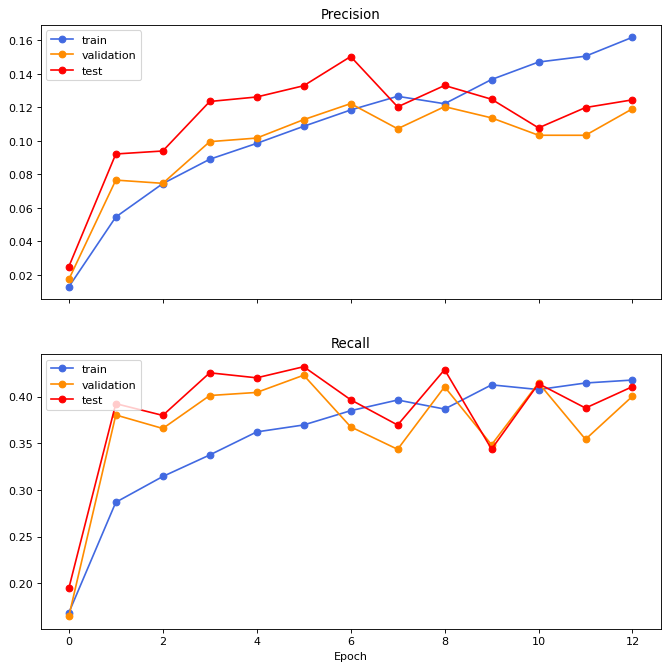

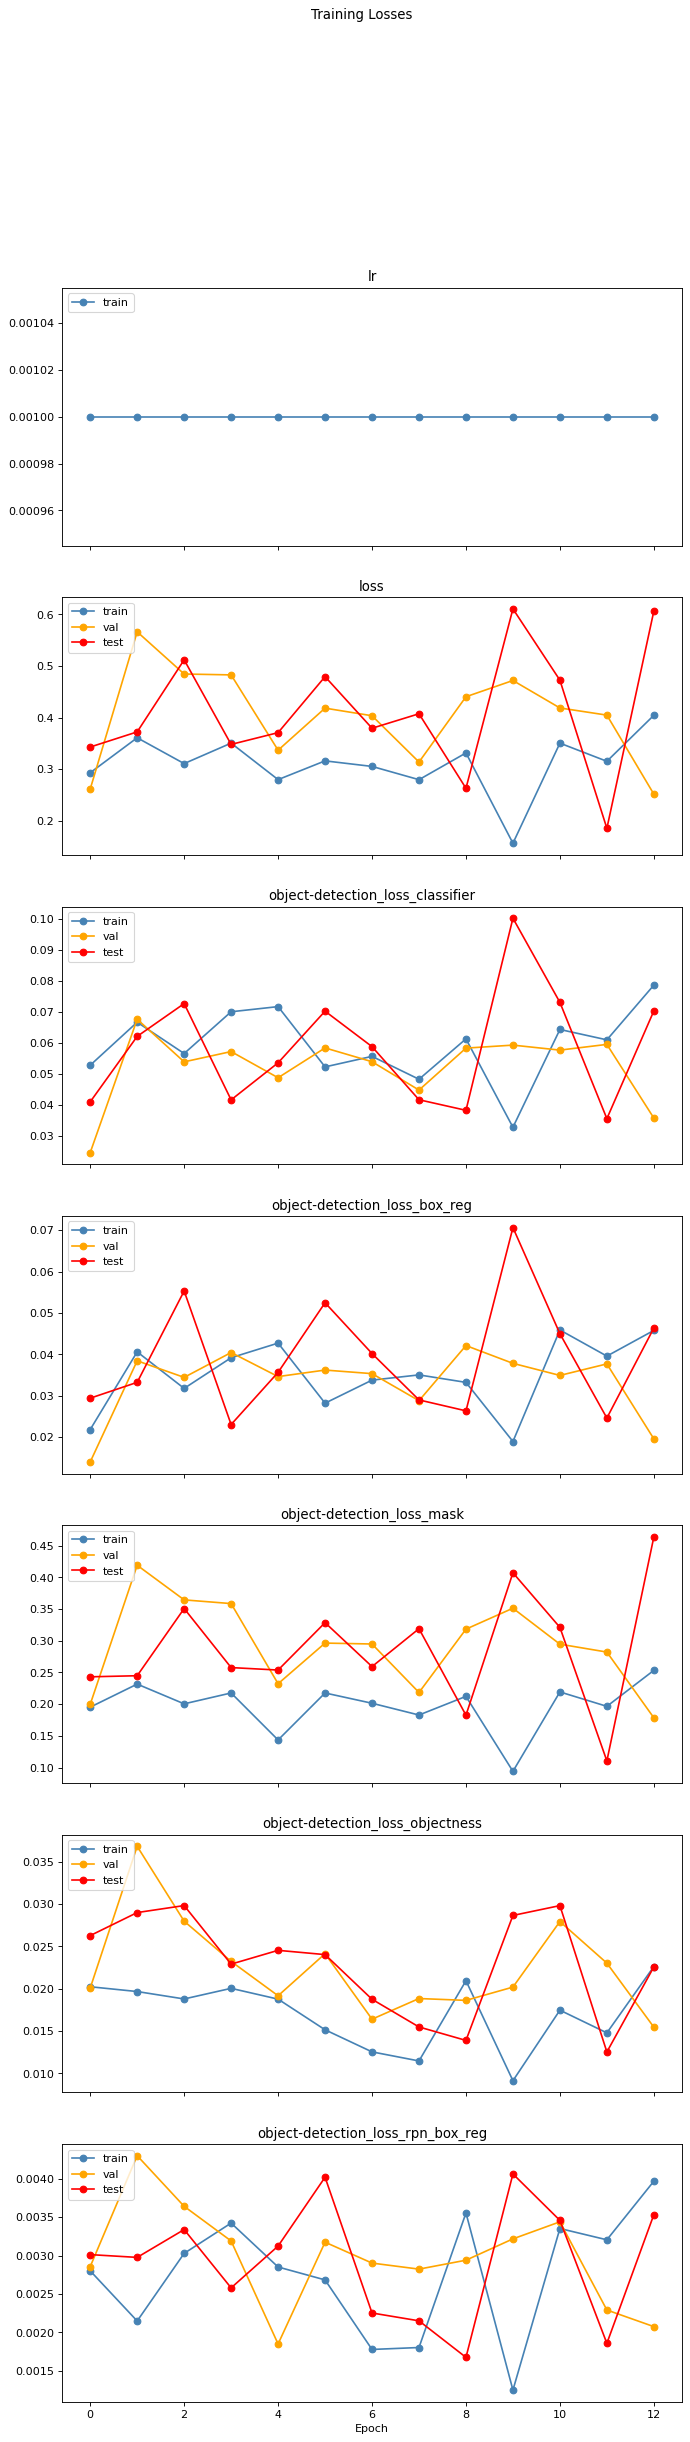

====================| Epoch [13] Done | It has took [222.32] min, Avg time: [1026.08] sec/epoch | Estimate time for [50] epochs: [855.06] min | Epoch took [919] sec | Patience [0] |====================
====================Training model: [baseline]====================
========================================For Training [baseline]========================================
ModelSetup(name='baseline', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, backbone_out_channels=64, batch_size=1, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones

In [11]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

for setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(setup)

    if setup.measure_test:
        # initialise the test recording list.
        train_info.test_ap_ars = []

    backbone = get_normal_backbone(setup)
    
    image_extractor = ImageFeatureExtractor(backbone)
    fusor = NoActionFusor()
    params = ObjectDetectionWithMaskParameters()
    performer = ObjectDetectionWithMaskPerformer(
        params,
        image_extractor.backbone.out_channels,
        len(DEFAULT_REFLACX_LABEL_COLS) + 1
    )
    
    model = ExtractFusePerform(
        feature_extractors= nn.ModuleDict({"image": image_extractor}),
        fusor=fusor,
        task_performers= nn.ModuleDict({"object-detection": performer}),
    )
    model= model.to(device)


    ################ Datasets ################
    dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        # "with_clinical": model_setup.use_clinical,
        "bbox_to_mask": True,
        "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
    }
    
    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=setup.batch_size,
    )

    train_coco = None
    train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        detect_eval_dataset,
        iou_thrs,
        use_iobb,
    )

    # dynamic_loss_weight = None
    loss_keys = [
        "object-detection_loss_box_reg",
        "object-detection_loss_classifier",
        "object-detection_loss_mask",
        "object-detection_loss_objectness",
        "object-detection_loss_rpn_box_reg",
    ]


    dynamic_loss_weight = DynamicWeightedLoss(
        keys=loss_keys + ["loss_mask"] if setup.use_mask else loss_keys
    )
    dynamic_loss_weight.to(device)
    print_params_setup(model)

    params = [p for p in model.parameters() if p.requires_grad]
    if dynamic_loss_weight:
        params += [p for p in dynamic_loss_weight.parameters()
                   if p.requires_grad]

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)
    lr_scheduler = get_lr_scheduler(optimizer, setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Took [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None
    
    # Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        if train_info.epoch > setup.gt_in_train_till:
            model.roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(
            get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(
                get_data_from_metric_logger(test_logger))
            test_ap_ar = get_ap_ar(
                train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
            )
            train_info.test_ap_ars.append(test_ap_ar)

        # update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

        plot_losses(train_info.train_losses, train_info.val_losses,
                    test_logers=train_info.test_losses)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if setup.save_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                setup=setup,
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


In [ ]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 29.706MB
